In [4]:
#! pip install pymc
#! pip install pytensor
%pip install --upgrade scipy seaborn



Note: you may need to restart the kernel to use updated packages.


In [5]:
%pip cache purge

Files removed: 2
Note: you may need to restart the kernel to use updated packages.


In [1]:
# Standard library imports
import numpy as np

# Third-party library imports
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import entropy

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import scale, OneHotEncoder
from sklearn.datasets import load_digits
from sklearn.preprocessing import StandardScaler


# PyMC and PyTensor imports
import pymc as pm
import pymc.math as pmath
import pytensor

# ArviZ imports
import arviz as az


ValueError: All ufuncs must have type `numpy.ufunc`. Received (<ufunc 'sph_legendre_p'>, <ufunc 'sph_legendre_p'>, <ufunc 'sph_legendre_p'>)

In [ ]:
SEED = 9927
rng = np.random.default_rng(SEED)

floatX = pytensor.config.floatX

The dataset used for this project is the Digits dataset, which is part of the sklearn library. It consists of 8x8 images of hand-written digits, represented as 64-dimensional feature vectors (flattened pixel values). The dataset includes 10 classes (digits 0 through 9), but for this task, only a subset of classes—0, 1, 2, 3, and 4—was selected for training, validation, and testing. The filtered dataset contains 901 samples, each with 64 features. Additionally, the digit 6 was excluded from training and validation but retained as a separate set of 181 samples to test the model’s behavior on out-of-distribution (OOD) data.

The filtered dataset was split into three subsets: a training set containing 576 samples, a validation set with 144 samples, and a test set consisting of 181 samples. The excluded OOD dataset was not used during training or validation but will be leveraged during testing to evaluate the model's ability to handle unseen data.

Before splitting, all features were standardized using StandardScaler. The scaler was fitted on the training data to compute the mean and standard deviation, which were then used to transform the validation, test, and excluded datasets. This standardization ensures that all features are on the same scale, preventing any feature from dominating due to larger numeric ranges.


In [ ]:
data, labels = load_digits(return_X_y=True)
print(data.shape)
print(labels.shape)
print(labels)

(1797, 64)
(1797,)
[0 1 2 ... 8 9 8]


In [ ]:
selected_classes = [0, 1, 2, 3, 4]
mask = [label in selected_classes for label in labels]
X_filtered = data[mask]
y_filtered = labels[mask]

# Verifică forma noilor array-uri
print(f"X_filtered shape: {X_filtered.shape}")
print(f"y_filtered shape: {y_filtered.shape}")

X_excluded = data[labels == 6]
y_excluded = labels[labels == 6]
print(f"X_excluded shape: {X_excluded.shape}")
print(f"y_excluded shape: {y_excluded.shape}")
print()

X_train, X_test, y_train, y_test = train_test_split(X_filtered, y_filtered, test_size=0.2, random_state=SEED)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=SEED)

scaler = StandardScaler()
X_train  = scaler.fit_transform(X_train)  # Învățăm și aplicăm scalarea pe datele de antrenare
X_val  = scaler.transform(X_val)  # Aplicăm scalarea pe datele de validare
X_test  = scaler.transform(X_test)  # Aplicăm scalarea pe datele de test
X_excluded = scaler.transform(X_excluded)

X_train = X_train.astype(floatX)
X_val = X_val.astype(floatX)
X_test = X_test.astype(floatX)
X_excluded = X_excluded.astype(floatX)


# Afișează dimensiunile seturilor scalate
print(f"X_train_scaled shape: {X_train.shape}")
print(f"X_val_scaled shape: {X_val.shape}")
print(f"X_test_scaled shape: {X_test.shape}")




X_filtered shape: (901, 64)
y_filtered shape: (901,)
X_excluded shape: (181, 64)
y_excluded shape: (181,)

X_train_scaled shape: (576, 64)
X_val_scaled shape: (144, 64)
X_test_scaled shape: (181, 64)


Proporțiile claselor pentru Antrenare:
  Clasa 0: 115 (19.97%)
  Clasa 1: 108 (18.75%)
  Clasa 2: 120 (20.83%)
  Clasa 3: 122 (21.18%)
  Clasa 4: 111 (19.27%)



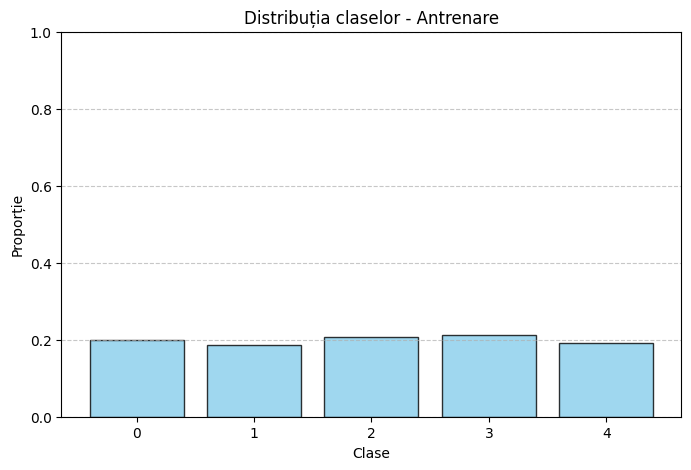

Proporțiile claselor pentru Validare:
  Clasa 0: 28 (19.44%)
  Clasa 1: 33 (22.92%)
  Clasa 2: 25 (17.36%)
  Clasa 3: 26 (18.06%)
  Clasa 4: 32 (22.22%)



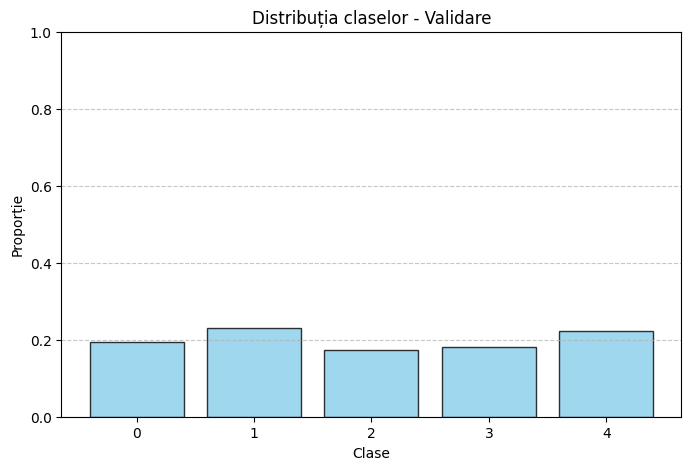

Proporțiile claselor pentru Test:
  Clasa 0: 35 (19.34%)
  Clasa 1: 41 (22.65%)
  Clasa 2: 32 (17.68%)
  Clasa 3: 35 (19.34%)
  Clasa 4: 38 (20.99%)



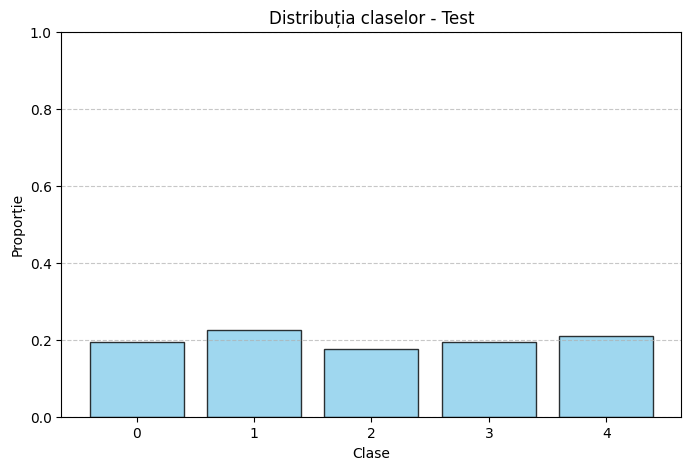

Proporțiile claselor pentru Excludere:
  Clasa 6: 181 (100.00%)



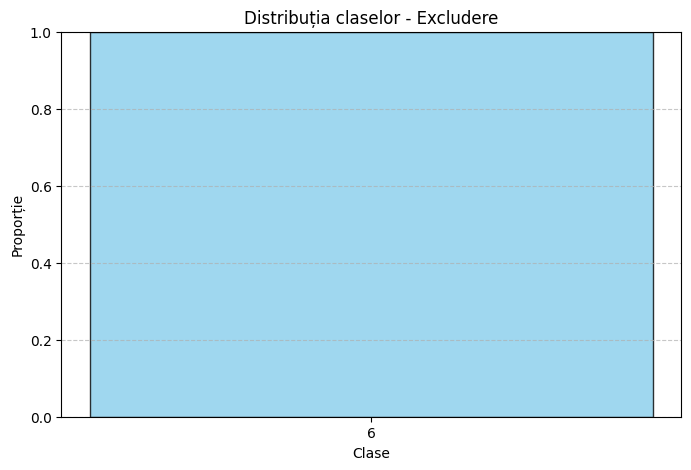

In [ ]:
import matplotlib.pyplot as plt
from collections import Counter

# Funcție pentru a calcula proporțiile claselor și a le afișa
def display_class_proportions_and_plot(labels, set_name):
    class_counts = Counter(labels)  # Numărăm aparițiile fiecărei clase
    total = sum(class_counts.values())  # Calculăm totalul etichetelor

    # Calculăm proporțiile claselor
    classes = sorted(class_counts.keys())
    proportions = [class_counts[cls] / total for cls in classes]

    # Afișăm proporțiile claselor
    print(f"Proporțiile claselor pentru {set_name}:")
    for cls, count in sorted(class_counts.items()):
        proportion = count / total
        print(f"  Clasa {cls}: {count} ({proportion:.2%})")
    print()

    # Creăm un bar plot pentru proporțiile claselor
    plt.figure(figsize=(8, 5))
    plt.bar(classes, proportions, color='skyblue', alpha=0.8, edgecolor='black')
    plt.title(f"Distribuția claselor - {set_name}")
    plt.xlabel("Clase")
    plt.ylabel("Proporție")
    plt.xticks(classes)  # Setăm clasele pe axa X
    plt.ylim(0, 1)  # Axa Y între 0 și 1 (proporție)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.show()

# Afișăm și vizualizăm proporțiile pentru fiecare set
display_class_proportions_and_plot(y_train, "Antrenare")
display_class_proportions_and_plot(y_val, "Validare")
display_class_proportions_and_plot(y_test, "Test")
display_class_proportions_and_plot(y_excluded, "Excludere")


In [ ]:
# X, y = load_digits(return_X_y=True)

# X_used = X[np.isin(y, [0, 1, 2, 3, 5])]
# y_used = y[np.isin(y, [0, 1, 2, 3, 5])]

# X_novel = X[y == 6]
# y_novel = y[y == 6]

# X_train, X_test, y_train, y_test = train_test_split(X_used, y_used, test_size=0.2, random_state=SEED)

# X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=SEED)

# scaler = StandardScaler()
# X_train = scaler.fit_transform(X_train).astype(floatX)
# X_val = scaler.transform(X_val).astype(floatX)
# X_test = scaler.transform(X_test).astype(floatX)
# X_novel = scaler.transform(X_novel).astype(floatX)

In [ ]:
# class_to_label = {0:0, 1:1, 2:2, 3:3, 5:4}
# y_train = np.array([class_to_label[label] for label in y_train])
# y_val = np.array([class_to_label[label] for label in y_val])
# y_test = np.array([class_to_label[label] for label in y_test])

In [ ]:
y_train = y_train.astype(floatX)
y_val = y_val.astype(floatX)
y_test = y_test.astype(floatX)
y_novel = y_excluded.astype(floatX)

In [ ]:
print(X_train.shape, y_train.shape)
print(X_val.shape, y_val.shape)
print(X_test.shape, y_test.shape)
print(X_excluded.shape, y_novel.shape)

(576, 64) (576,)
(144, 64) (144,)
(181, 64) (181,)
(181, 64) (181,)


In [ ]:
def construct_bnn(network_input, bnn_output, hidden_layer_neurons, class_nr):
  # Initialize random weights between each layer
  init_1 = rng.standard_normal(size=(network_input.shape[1], hidden_layer_neurons)).astype(floatX)
  init_2 = rng.standard_normal(size=(hidden_layer_neurons, hidden_layer_neurons)).astype(floatX)
  init_out = rng.standard_normal(size=(hidden_layer_neurons, class_nr)).astype(floatX)

  # Define coords parameter for training the model
  coords = {
      "hidden_layer_1": np.arange(hidden_layer_neurons),
      "hidden_layer_2": np.arange(hidden_layer_neurons),
      "output_layer": np.arange(class_nr),
      "train_cols": np.arange(network_input.shape[1]),
  }

  with pm.Model(coords=coords) as bayesian_neural_network:
    network_input = pm.Data("network_input", X_train, dims=("obs_id", "train_cols"))
    bnn_output = pm.Data("bnn_output", y_train, dims="obs_id")

    # Weights from input to first hidden layer
    weights_in_1 = pm.Normal("w_in_1", mu=0, sigma=1, initval=init_1, dims=("train_cols", "hidden_layer_1"))

    # Weights from first hidden layer to second hidden layer
    weights_1_2 = pm.Normal("w_1_2", mu=0, sigma=1, initval=init_2, dims=("hidden_layer_1", "hidden_layer_2"))

    # Weights from second hidden layer to output layer
    weights_2_out = pm.Normal("w_2_out", mu=0, sigma=1, initval=init_out, dims=("hidden_layer_2", "output_layer"))

    # Build bayesian neural network using tanh activation function
    act_1 = pm.math.tanh(pm.math.dot(network_input, weights_in_1))
    act_2 = pm.math.tanh(pm.math.dot(act_1, weights_1_2))
    act_out = pm.math.softmax(pm.math.dot(act_2, weights_2_out), axis=-1)

    # Multiclass clasification -> Categorical likelihood
    out = pm.Categorical("out", p=act_out, observed=bnn_output, total_size=y_train.shape[0], dims="obs_id")
    act_out = pm.Deterministic("act_out", act_out)

  return bayesian_neural_network

In [ ]:
hidden_layer_neurons = 18
class_nr = len(set(y_train))

bnn_model = construct_bnn(X_train, y_train, hidden_layer_neurons, class_nr)

In [ ]:
with bnn_model:
  approx = pm.fit(n=20000)

Output()

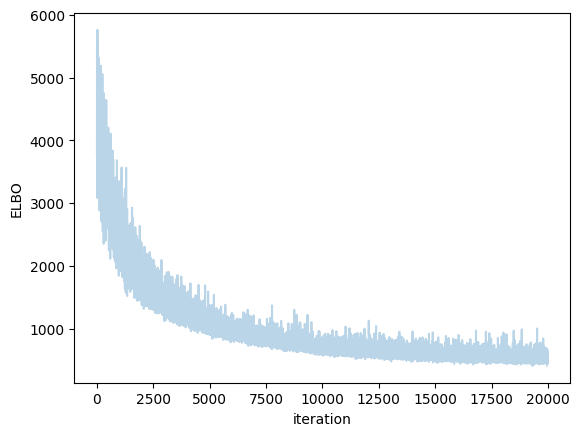

In [ ]:
plt.plot(approx.hist, alpha=0.3)
plt.ylabel("ELBO")
plt.xlabel("iteration")
plt.show()

In [ ]:
trace = approx.sample(draws=5000)
with bnn_model:
  pm.set_data({"network_input": X_val, "bnn_output": y_val}, coords={
    "hidden_layer_1": np.arange(hidden_layer_neurons),
    "hidden_layer_2": np.arange(hidden_layer_neurons),
    "output_layer": np.arange(class_nr),
    "train_cols": np.arange(X_val.shape[1])
  })
  ppc = pm.sample_posterior_predictive(trace, var_names=["out", "act_out"])
  trace.extend(ppc)

Output()

In [ ]:
trace = approx.sample(draws=5000)
with bnn_model:
  pm.set_data({"network_input": X_test}, coords={
    "hidden_layer_1": np.arange(hidden_layer_neurons),
    "hidden_layer_2": np.arange(hidden_layer_neurons),
    "output_layer": np.arange(class_nr),
    "train_cols": np.arange(X_test.shape[1])

  })
  ppc = pm.sample_posterior_predictive(trace, var_names=["out", "act_out"])
  trace.extend(ppc)

Output()

In [ ]:
print(ppc.posterior_predictive['out'])
print(ppc.posterior_predictive['out'].shape)

<xarray.DataArray 'out' (chain: 1, draw: 5000, obs_id: 181)> Size: 7MB
array([[[2, 0, 4, ..., 3, 3, 2],
        [2, 0, 4, ..., 3, 3, 3],
        [2, 0, 4, ..., 3, 2, 3],
        ...,
        [2, 0, 4, ..., 3, 3, 3],
        [2, 0, 4, ..., 3, 3, 3],
        [2, 0, 4, ..., 3, 3, 3]]])
Coordinates:
  * chain    (chain) int64 8B 0
  * draw     (draw) int64 40kB 0 1 2 3 4 5 6 ... 4994 4995 4996 4997 4998 4999
  * obs_id   (obs_id) int64 1kB 0 1 2 3 4 5 6 7 ... 174 175 176 177 178 179 180
(1, 5000, 181)


In [ ]:

def calculate_accuracy(ppc, y_test, floatX):
    """
    Calculează predicțiile și acuratețea unui model pe baza mostrelor din posterior predictive.

    Parametri:
        ppc (dict): Posterior predictive din modelul Bayesian.
        y_test (array): Etichetele reale pentru setul de test.
        floatX (dtype): Tipul de date pentru predicții.

    Returnează:
        tuple: Un array cu predicțiile și acuratețea (accuracy).
    """
    preds = []  # Lista pentru predicții

    # Iterăm prin fiecare punct de test
    for test_point in range(ppc['out'].shape[2]):
        class_votes = []  # Lista pentru voturile fiecărei clase

        for draw in ppc['out'][0]:  # Fiecare draw din posterior predictive
            class_votes.append(draw[test_point])

        # Determinăm clasa cu cele mai multe voturi
        predicted_class = np.argmax(np.bincount(class_votes))
        preds.append(predicted_class.astype(floatX))

    # Convertim lista de predicții într-un array
    preds = np.array(preds)

    # Calculăm acuratețea
    accuracy = (preds == y_test).mean()
    print(f"Accuracy: {accuracy}")

    return preds, accuracy

preds, accuracy = calculate_accuracy(ppc.posterior_predictive, y_test, floatX)


Accuracy: 0.9834254143646409


UNCERTANTY

(1, 5000, 181, 5)


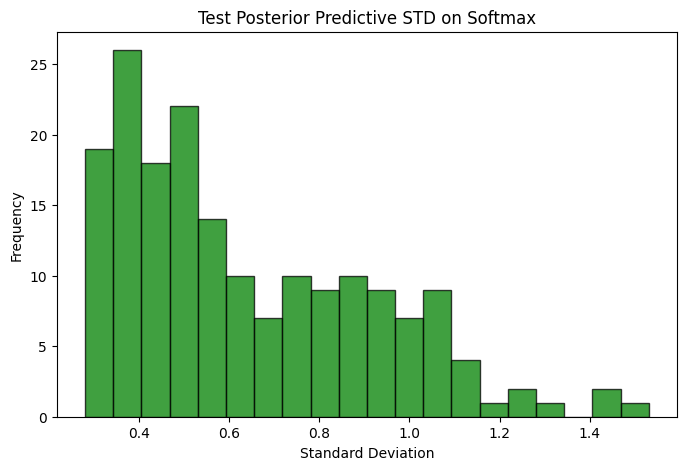

181

In [ ]:
def calculate_uncertainty(predictions, label='Test'):
    """
    Calculează incertitudinea totală (suma deviațiilor standard) pentru fiecare punct de test.
    """
    uncertainty_values = []  # Lista pentru incertitudini totale
    print(predictions.shape)

    for test_idx in range(predictions.shape[2]):
        # Extragem predicțiile softmax pentru punctul curent
        softmax_draws = predictions[0, :, test_idx, :]  # Dimensiune: (n_draws, n_classes)

        # Calculăm deviația standard pentru fiecare clasă
        per_class_std = np.std(softmax_draws, axis=0)  # Dimensiune: (n_classes,)

        # Suma deviațiilor standard (incertitudinea totală)
        total_uncertainty = per_class_std.sum()

        # Salvăm incertitudinea totală
        uncertainty_values.append(total_uncertainty)

    # Convertim lista de incertitudini într-un array numpy
    uncertainty_array = np.array(uncertainty_values)

        # Vizualizăm distribuția incertitudinilor
    plt.figure(figsize=(8, 5))
    plt.hist(uncertainty_array, bins=20, color='green', alpha=0.75, edgecolor='black')
    plt.title(f"{label} Posterior Predictive STD on Softmax")
    plt.xlabel("Standard Deviation")
    plt.ylabel("Frequency")
    plt.show()

    return uncertainty_array

# Apelarea funcției cu aceleași date
uncertainty_array = calculate_uncertainty(ppc.posterior_predictive['act_out'], label='Test')
len(uncertainty_array)

Sumă probabilități pentru punctul 0: 1.000000000000002
Sumă probabilități pentru punctul 1: 1.000000000000003
Sumă probabilități pentru punctul 2: 0.9999999999999988
Sumă probabilități pentru punctul 3: 1.0000000000000009
Sumă probabilități pentru punctul 4: 0.9999999999999973
Sumă probabilități pentru punctul 5: 1.0000000000000016
Sumă probabilități pentru punctul 6: 0.9999999999999962
Sumă probabilități pentru punctul 7: 0.9999999999999944
Sumă probabilități pentru punctul 8: 0.9999999999999997
Sumă probabilități pentru punctul 9: 1.0000000000000009
Sumă probabilități pentru punctul 10: 1.000000000000001
Sumă probabilități pentru punctul 11: 0.9999999999999987
Sumă probabilități pentru punctul 12: 0.9999999999999971
Sumă probabilități pentru punctul 13: 0.9999999999999981
Sumă probabilități pentru punctul 14: 0.9999999999999991
Sumă probabilități pentru punctul 15: 0.9999999999999998
Sumă probabilități pentru punctul 16: 0.9999999999999972
Sumă probabilități pentru punctul 17: 0.9999

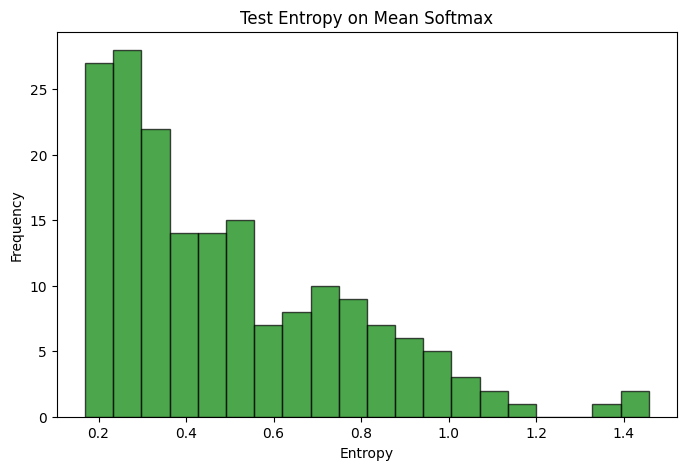

array([0.18035837, 0.36601713, 0.32179046, 0.39834286, 0.4426343 ,
       0.33035518, 0.28700517, 0.287783  , 0.63755443, 0.79816524,
       0.92897578, 0.22510751, 0.38797695, 0.35723676, 0.2872408 ,
       0.78187938, 0.68396473, 0.24820795, 0.48824662, 0.91335603,
       1.06841682, 0.58204514, 0.59049496, 0.50761778, 0.443772  ,
       0.56473327, 0.22657768, 0.5442427 , 0.19519716, 0.45078816,
       1.37059569, 0.61304868, 0.43013367, 0.24110187, 0.92166781,
       0.30356303, 1.08330903, 0.49737487, 0.28594143, 0.25843203,
       0.50935619, 0.50849222, 0.62218678, 0.72617157, 0.5343497 ,
       0.34957777, 0.29870658, 0.96703069, 0.73883999, 0.34596721,
       0.33698531, 0.25705057, 0.77383972, 0.45453556, 0.22901548,
       0.57949425, 0.4535658 , 0.74845926, 0.41646919, 0.70825812,
       0.23540439, 0.31736043, 0.27952375, 0.41434706, 0.65977675,
       0.24654494, 0.48133005, 0.23319756, 0.94208232, 0.23819701,
       0.5255173 , 1.45721189, 0.20201119, 0.41406104, 0.34600

In [ ]:
def compute_entropy(probabilities, epsilon=1e-10):
    """
    Calculează entropia pentru un set de probabilități.
    """
    total_entropy = 0

    for prob in probabilities:
        total_entropy += prob * np.log(prob + epsilon)
    return -total_entropy


# Metoda alternativă pentru calculul incertitudinii bazată pe entropia mediei
def calculate_mean_entropy(predictions, label='Test', epsilon=1e-10):
    """
    Calculează incertitudinea pe baza entropiei mediei softmax pentru fiecare punct de test.
    """
    uncertainty_values = []

    # Iterăm prin fiecare punct de test
    for test_idx in range(predictions.shape[2]):
        # Extragem predicțiile softmax pentru punctul curent
        softmax_draws = predictions[0, :, test_idx, :]  # Dimensiune: (n_draws, n_classes)

        softmax_draws = softmax_draws.values
        # Calculăm media probabilităților pentru fiecare clasă
        averaged_probs = np.mean(softmax_draws, axis=0)  # Dimensiune: (n_classes,)

        print(f"Sumă probabilități pentru punctul {test_idx}: {np.sum(averaged_probs)}")


        # Calculăm entropia mediei probabilităților
        #point_entropy = compute_entropy(averaged_probs, epsilon)
        point_entropy = entropy(averaged_probs)

        # Salvăm entropia pentru punctul curent
        uncertainty_values.append(point_entropy)

    # Convertim lista de incertitudini într-un array numpy
    uncertainty_array = np.array(uncertainty_values)


        # Vizualizăm distribuția incertitudinii (histogramă)
    plt.figure(figsize=(8, 5))
    plt.hist(uncertainty_array, bins=20, color='green', alpha=0.7, edgecolor='black')
    plt.title(f"{label} Entropy on Mean Softmax")
    plt.xlabel("Entropy")
    plt.ylabel("Frequency")
    plt.show()

    return uncertainty_array


# Apelarea funcției
calculate_mean_entropy(ppc.posterior_predictive['act_out'], label='Test')


TEST ON THE EXCLUDED CLASS
I analyzed the standard deviation chart and concluded that the chosen threshold to determine whether a sample belongs to the novel class is 1.0.

In [ ]:
trace = approx.sample(draws=5000)
with bnn_model:
  pm.set_data({"network_input": X_excluded, "bnn_output": y_excluded}, coords={
    "hidden_layer_1": np.arange(hidden_layer_neurons),
    "hidden_layer_2": np.arange(hidden_layer_neurons),
    "output_layer": np.arange(class_nr),
    "train_cols": np.arange(X_val.shape[1])
  })
  ppc = pm.sample_posterior_predictive(trace, var_names=["out", "act_out"])
  trace.extend(ppc)

Output()

In [ ]:
preds_excluded, accuracy_excluded = calculate_accuracy(ppc.posterior_predictive, y_excluded, floatX)
preds_excluded

Accuracy: 0.0


array([1., 1., 4., 1., 4., 4., 4., 0., 1., 1., 1., 4., 1., 4., 1., 1., 4.,
       0., 4., 4., 4., 0., 1., 4., 0., 0., 4., 0., 4., 0., 0., 0., 4., 4.,
       0., 4., 0., 0., 4., 4., 4., 4., 0., 4., 4., 4., 4., 1., 1., 4., 4.,
       1., 0., 0., 0., 0., 0., 4., 0., 4., 4., 1., 0., 4., 4., 4., 4., 4.,
       0., 4., 4., 4., 4., 4., 4., 4., 4., 0., 4., 1., 4., 1., 4., 4., 4.,
       4., 4., 4., 1., 4., 0., 4., 0., 0., 0., 4., 0., 0., 0., 4., 4., 4.,
       4., 0., 4., 4., 1., 2., 4., 4., 4., 1., 4., 4., 2., 4., 0., 0., 4.,
       4., 0., 4., 1., 1., 4., 4., 4., 1., 2., 2., 1., 2., 2., 1., 1., 4.,
       1., 4., 2., 1., 4., 0., 4., 4., 0., 4., 0., 4., 0., 4., 4., 4., 4.,
       4., 4., 1., 4., 1., 1., 4., 4., 1., 4., 4., 1., 4., 1., 1., 4., 4.,
       4., 4., 4., 4., 4., 0., 4., 4., 0., 1., 4.])

Accuracy: 0.20994475138121546
(1, 5000, 181, 5)


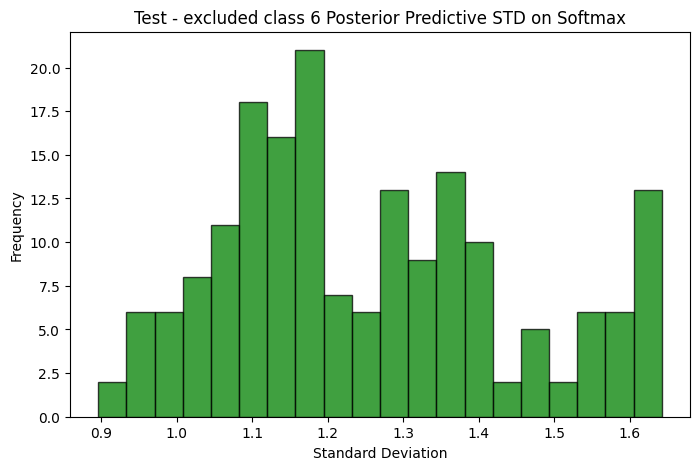

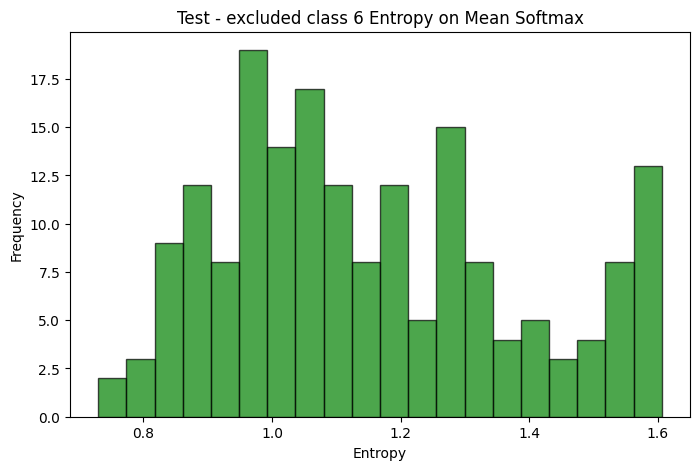

array([1.16524234, 0.98579111, 1.41784318, 0.95770522, 1.10575245,
       1.19673478, 1.56643496, 1.10413686, 1.26568683, 1.03105474,
       0.80637747, 0.87788442, 0.84044168, 1.19487744, 1.2465126 ,
       1.27442158, 0.95552557, 1.29852285, 1.04485271, 1.17299243,
       0.96600363, 1.10893221, 0.97890057, 0.97857348, 1.0406721 ,
       0.99605855, 0.98052808, 1.01059994, 1.44297272, 1.28155704,
       1.03576315, 1.1969977 , 1.54723065, 1.20779734, 1.10158534,
       1.46635756, 1.00173731, 1.04481653, 0.79709573, 1.02966482,
       1.26032256, 1.24388022, 1.50210686, 1.08677983, 0.96177005,
       1.2859174 , 1.32467759, 1.11665619, 1.31828825, 0.96344267,
       1.06552805, 1.52660181, 1.29410466, 1.1666428 , 1.50218726,
       1.3577217 , 1.15762414, 1.31905389, 0.99380779, 1.17285886,
       1.2187104 , 1.43133553, 1.51572303, 1.31073211, 1.15870925,
       0.89313708, 0.99084793, 0.91044295, 1.04033428, 0.96148979,
       0.90798664, 0.90119956, 0.83858995, 1.55855784, 1.04606

In [ ]:
preds_excluded, accuracy_excluded = calculate_accuracy(ppc.posterior_predictive, y_test, floatX)
uncertainty_array = calculate_uncertainty(ppc.posterior_predictive['act_out'], label='Test - excluded class 6')
len(uncertainty_array)
calculate_mean_entropy(ppc.posterior_predictive['act_out'], label='Test - excluded class 6')


Apply the threshold, see the accuracy

CREATE NEURAL NETWORK AND COMPARE THE RESULTS


In [ ]:
def classify_samples_based_on_threshold(uncertainty_array, threshold):
    classifications = (uncertainty_array > threshold).astype(int)
    novel_indices = np.where(classifications == 1)[0]
    return classifications, novel_indices


In [ ]:
# Setăm threshold-ul
threshold = 0.4

# Aplicăm funcția de clasificare
classifications, novel_indices = classify_samples_based_on_threshold(uncertainty_array, threshold)

# Afișăm rezultatele
print(f"Total samples: {len(uncertainty_array)}")
print(f"Samples classified as novel: {len(novel_indices)}")
print(f"Indices of novel samples: {novel_indices}")


Total samples: 181
Samples classified as novel: 141
Indices of novel samples: [  1   2   3   4   5   6   7   8   9  10  12  13  14  15  16  18  19  20
  21  22  23  24  25  27  29  30  31  32  34  35  36  37  38  40  41  42
  43  44  45  46  47  48  49  50  51  52  53  55  56  57  58  59  61  62
  63  64  66  68  70  71  73  74  75  76  77  78  79  81  82  84  87  89
  91  92  93  94  95  96  97  98  99 100 102 103 104 105 106 107 108 109
 111 113 117 118 120 121 122 123 124 125 127 129 130 131 132 133 137 138
 139 141 142 143 144 145 146 147 149 150 151 152 153 155 156 157 160 161
 162 163 164 165 166 167 168 169 170 171 172 174 175 177 179]


[2. 0. 4. 1. 1. 2. 4. 2. 2. 1. 1. 0. 1. 1. 4. 3. 2. 0. 3. 1. 3. 2. 2. 4.
 1. 4. 4. 4. 0. 1. 4. 4. 2. 0. 3. 4. 1. 2. 0. 0. 2. 4. 0. 3. 1. 4. 4. 1.
 1. 3. 4. 0. 4. 1. 0. 0. 3. 2. 3. 1. 3. 0. 4. 4. 2. 0. 1. 0. 1. 2. 4. 2.
 0. 2. 4. 0. 4. 1. 0. 2. 3. 2. 4. 0. 2. 3. 4. 2. 0. 2. 0. 2. 3. 4. 3. 0.
 4. 1. 4. 1. 1. 0. 3. 3. 3. 2. 2. 1. 3. 0. 4. 1. 2. 1. 0. 3. 2. 4. 2. 4.
 3. 3. 3. 4. 3. 3. 0. 1. 0. 1. 1. 3. 1. 1. 3. 4. 0. 1. 1. 1. 0. 0. 3. 3.
 1. 3. 1. 1. 0. 2. 1. 4. 4. 4. 2. 4. 0. 0. 2. 0. 1. 4. 1. 1. 3. 4. 1. 3.
 4. 2. 3. 2. 1. 2. 4. 3. 0. 0. 3. 3. 3. 6. 6. 6. 6. 6. 6. 6. 6. 6. 6. 6.
 6. 6. 6. 6. 6. 6. 6. 6. 6.]
20
(1, 5000, 181, 5)


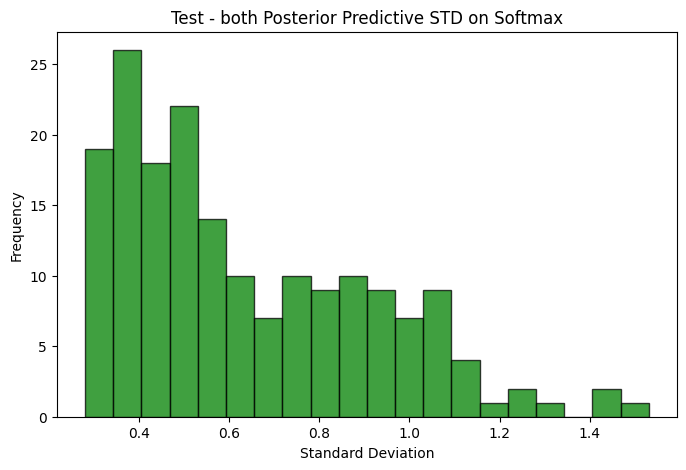

Total samples: 181
Samples classified as novel: 141
Indices of novel samples: [  1   2   3   4   5   6   7   8   9  10  12  13  14  15  16  18  19  20
  21  22  23  24  25  27  29  30  31  32  34  35  36  37  38  40  41  42
  43  44  45  46  47  48  49  50  51  52  53  55  56  57  58  59  61  62
  63  64  66  68  70  71  73  74  75  76  77  78  79  81  82  84  87  89
  91  92  93  94  95  96  97  98  99 100 102 103 104 105 106 107 108 109
 111 113 117 118 120 121 122 123 124 125 127 129 130 131 132 133 137 138
 139 141 142 143 144 145 146 147 149 150 151 152 153 155 156 157 160 161
 162 163 164 165 166 167 168 169 170 171 172 174 175 177 179]


In [ ]:
X_test_augmented = np.vstack([X_test, X_excluded[:20]])  # Adăugăm noile exemple
y_test_augmented = np.concatenate([y_test, y_excluded[:20]])  # Adăugăm etichetele noi


In [ ]:
trace = approx.sample(draws=5000)
with bnn_model:
  pm.set_data({"network_input": X_test_augmented, "bnn_output": y_test_augmented}, coords={
    "hidden_layer_1": np.arange(hidden_layer_neurons),
    "hidden_layer_2": np.arange(hidden_layer_neurons),
    "output_layer": np.arange(class_nr),
    "train_cols": np.arange(X_val.shape[1])
  })
  ppc = pm.sample_posterior_predictive(trace, var_names=["out", "act_out"])
  trace.extend(ppc)

Output()

[2. 0. 4. 1. 1. 2. 4. 2. 2. 1. 1. 0. 1. 1. 4. 3. 2. 0. 3. 1. 3. 2. 2. 4.
 1. 4. 4. 4. 0. 1. 4. 4. 2. 0. 3. 4. 1. 2. 0. 0. 2. 4. 0. 3. 1. 4. 4. 1.
 1. 3. 4. 0. 4. 1. 0. 0. 3. 2. 3. 1. 3. 0. 4. 4. 2. 0. 1. 0. 1. 2. 4. 2.
 0. 2. 4. 0. 4. 1. 0. 2. 3. 2. 4. 0. 2. 3. 4. 2. 0. 2. 0. 2. 3. 4. 3. 0.
 4. 1. 4. 1. 1. 0. 3. 3. 3. 2. 2. 1. 3. 0. 4. 1. 2. 1. 0. 3. 2. 4. 2. 4.
 3. 3. 3. 4. 3. 3. 0. 1. 0. 1. 1. 3. 1. 1. 3. 4. 0. 1. 1. 1. 0. 0. 3. 3.
 1. 3. 1. 1. 0. 2. 1. 4. 4. 4. 2. 4. 0. 0. 2. 0. 1. 4. 1. 1. 3. 4. 1. 3.
 4. 2. 3. 2. 1. 2. 4. 3. 0. 0. 3. 3. 3. 6. 6. 6. 6. 6. 6. 6. 6. 6. 6. 6.
 6. 6. 6. 6. 6. 6. 6. 6. 6.]
20
(1, 5000, 201, 5)


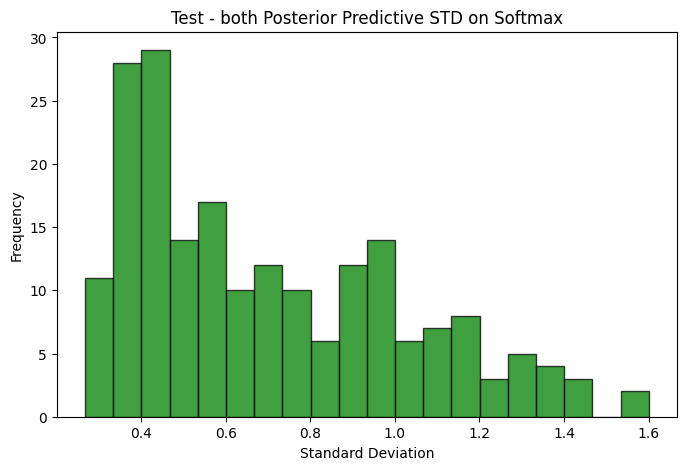

Total samples: 201
Samples classified as novel: 39
Indices of novel samples: [ 10  19  20  30  34  36  47  68  71  78  97 108 122 130 138 143 145 146
 160 161 168 171 181 182 183 184 185 186 187 188 189 190 194 195 196 197
 198 199 200]


In [ ]:
print(y_test_augmented)
print(np.sum(y_test_augmented == 6) )
uncertainty_array = calculate_uncertainty(ppc.posterior_predictive['act_out'], label='Test - both')
classifications, novel_indices = classify_samples_based_on_threshold(uncertainty_array, threshold= 1.0)

# Afișăm rezultatele
print(f"Total samples: {len(uncertainty_array)}")
print(f"Samples classified as novel: {len(novel_indices)}")
print(f"Indices of novel samples: {novel_indices}")


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import accuracy_score


In [ ]:
class NormalNeuralNetwork(nn.Module):
    def __init__(self, input_dim, num_classes):
        super(NormalNeuralNetwork, self).__init__()
        self.fc1 = nn.Linear(input_dim, 128)  # Primul strat ascuns
        self.fc2 = nn.Linear(128, 64)        # Al doilea strat ascuns
        self.fc3 = nn.Linear(64, num_classes)  # Strat de ieșire
        self.relu = nn.ReLU()
        self.softmax = nn.Softmax(dim=1)

    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.softmax(self.fc3(x))
        return x

# Configurare inițială
input_dim = X_train.shape[1]
num_classes = len(np.unique(y_train))
np.unique(y_train)

array([0., 1., 2., 3., 4.])

In [ ]:
# Conversie date în tensori PyTorch
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.long)

X_val_tensor = torch.tensor(X_val, dtype=torch.float32)
y_val_tensor = torch.tensor(y_val, dtype=torch.long)

X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.long)


In [ ]:
# Inițializare model, funcție de pierdere și optimizator
model = NormalNeuralNetwork(input_dim, num_classes)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [ ]:
# Funcție pentru antrenare
def train_model(model, X_train, y_train, X_val, y_val, epochs=20, batch_size=32):
    for epoch in range(epochs):
        model.train()
        epoch_loss = 0
        correct = 0

        # Antrenare pe batch-uri
        for i in range(0, X_train.shape[0], batch_size):
            X_batch = X_train[i:i+batch_size]
            y_batch = y_train[i:i+batch_size]

            optimizer.zero_grad()  # Resetăm gradientele
            outputs = model(X_batch)
            loss = criterion(outputs, y_batch)
            loss.backward()  # Calculăm gradientele
            optimizer.step()  # Actualizăm parametrii

            epoch_loss += loss.item()
            preds = outputs.argmax(dim=1)
            correct += (preds == y_batch).sum().item()

        # Evaluare pe setul de validare
        model.eval()
        with torch.no_grad():
            val_outputs = model(X_val)
            val_preds = val_outputs.argmax(dim=1)
            val_accuracy = (val_preds == y_val).float().mean().item()

        print(f"Epoch {epoch+1}/{epochs}, Loss: {epoch_loss:.4f}, Train Accuracy: {correct/X_train.shape[0]:.4f}, Val Accuracy: {val_accuracy:.4f}")


In [ ]:
train_model(model, X_train_tensor, y_train_tensor, X_val_tensor, y_val_tensor, epochs=10)


Epoch 1/10, Loss: 27.7881, Train Accuracy: 0.5590, Val Accuracy: 0.8472
Epoch 2/10, Loss: 23.1243, Train Accuracy: 0.8750, Val Accuracy: 0.9236
Epoch 3/10, Loss: 18.6402, Train Accuracy: 0.9462, Val Accuracy: 0.9653
Epoch 4/10, Loss: 17.2139, Train Accuracy: 0.9757, Val Accuracy: 0.9792
Epoch 5/10, Loss: 16.7968, Train Accuracy: 0.9896, Val Accuracy: 0.9931
Epoch 6/10, Loss: 16.6162, Train Accuracy: 0.9913, Val Accuracy: 1.0000
Epoch 7/10, Loss: 16.5076, Train Accuracy: 0.9948, Val Accuracy: 1.0000
Epoch 8/10, Loss: 16.4447, Train Accuracy: 0.9965, Val Accuracy: 1.0000
Epoch 9/10, Loss: 16.3971, Train Accuracy: 0.9983, Val Accuracy: 1.0000
Epoch 10/10, Loss: 16.3643, Train Accuracy: 1.0000, Val Accuracy: 1.0000


In [ ]:
# Evaluarea pe setul de test
model.eval()
with torch.no_grad():
    test_outputs = model(X_test_tensor)
    test_preds = test_outputs.argmax(dim=1)
    test_accuracy = accuracy_score(y_test, test_preds.numpy())
    print(f"Test Accuracy: {test_accuracy:.4f}")

Test Accuracy: 1.0000


REGRESSION TASK


In [ ]:
# !pip install ucimlrepo


In [ ]:
import seaborn as sns

# Încărcăm dataset-ul Auto MPG
mpg = sns.load_dataset('mpg')

# Verificăm dacă există valori lipsă
print(mpg.isnull().sum())

# Verificăm informațiile despre dataset
print(mpg.info())

# Eliminăm rândurile cu valori lipsă
mpg = mpg.dropna()

# Selecția caracteristicilor și țintei
X = mpg[['cylinders', 'displacement', 'horsepower', 'weight', 'acceleration', 'model_year', 'origin']]
y = mpg['mpg']

print("Caracteristici (features):")
print(X.head())

print("\nȚintă (target):")
print(y.head())


mpg             0
cylinders       0
displacement    0
horsepower      6
weight          0
acceleration    0
model_year      0
origin          0
name            0
dtype: int64
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 398 entries, 0 to 397
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   mpg           398 non-null    float64
 1   cylinders     398 non-null    int64  
 2   displacement  398 non-null    float64
 3   horsepower    392 non-null    float64
 4   weight        398 non-null    int64  
 5   acceleration  398 non-null    float64
 6   model_year    398 non-null    int64  
 7   origin        398 non-null    object 
 8   name          398 non-null    object 
dtypes: float64(4), int64(3), object(2)
memory usage: 28.1+ KB
None
Caracteristici (features):
   cylinders  displacement  horsepower  weight  acceleration  model_year  \
0          8         307.0       130.0    3504          12.0          70   
1

In [ ]:
# 1. Eliminăm coloana `name` (nu este utilă)
mpg = mpg.drop(columns=['name'])

# 2. Completăm valorile lipsă din `horsepower` cu media coloanei
mpg['horsepower'] = mpg['horsepower'].fillna(mpg['horsepower'].mean())

# 3. Convertim `origin` la variabilă numerică (one-hot encoding)
mpg = pd.get_dummies(mpg, columns=['origin'], drop_first=True)

# 4. Selecția caracteristicilor și a țintei
X = mpg.drop(columns=['mpg'])  # Caracteristicile
y = mpg['mpg']  # Ținta (mpg)

# Afișăm dataset-ul pregătit
print(X.head())
print(y.head())


   cylinders  displacement  horsepower  weight  acceleration  model_year  \
0          8         307.0       130.0    3504          12.0          70   
1          8         350.0       165.0    3693          11.5          70   
2          8         318.0       150.0    3436          11.0          70   
3          8         304.0       150.0    3433          12.0          70   
4          8         302.0       140.0    3449          10.5          70   

   origin_japan  origin_usa  
0         False        True  
1         False        True  
2         False        True  
3         False        True  
4         False        True  
0    18.0
1    15.0
2    18.0
3    16.0
4    17.0
Name: mpg, dtype: float64


Dimensiuni X_train: (1070, 8)
Dimensiuni X_test: (268, 8)
Primele 5 exemple din X_train:
[[ 0.69727145  0.97878831  1.58092576 -1.0105187  -0.5074631  -0.56641788
   1.63579466 -0.56641788]
 [ 0.19886312 -0.73547651 -0.07876719 -1.0105187  -0.5074631  -0.56641788
   1.63579466 -0.56641788]
 [-0.65555117 -0.44839867 -0.90861367 -1.0105187  -0.5074631  -0.56641788
  -0.61132367 -0.56641788]
 [-0.58434998  1.44795552 -0.07876719  0.98959079 -0.5074631  -0.56641788
   1.63579466 -0.56641788]
 [ 0.69727145 -1.3211153  -0.07876719 -1.0105187  -0.5074631   1.76548098
  -0.61132367 -0.56641788]]
Primele 5 valori din y_train:
[10381.4787  7046.7222  4137.5227  3875.7341  9566.9909]


Corelația Spearman pe setul de test: 0.92


In [ ]:
# Interval pentru setul de antrenament
values = (mpg['cylinders'] >= 3) & (mpg['cylinders'] <= 6)


# Separăm toate datele pentru `cylinders = 8`
data_cyl_8 = mpg[mpg['cylinders'] == 8]

In [ ]:
mpg.to_csv("auto_mpg_preprocessed.csv", index=False)


NameError: name 'mpg' is not defined

In [ ]:
from sklearn.model_selection import train_test_split

# Împărțim datele în seturi de train și test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print("Shape of training data:", X_train.shape)
print("Shape of test data:", X_test.shape)


Shape of training data: (1070, 6)
Shape of test data: (268, 6)


In [ ]:
# Încărcăm dataset-ul Auto MPG
import seaborn as sns

mpg = sns.load_dataset("mpg").dropna()

# Selectăm caracteristicile și ținta
X = mpg[["cylinders", "displacement", "horsepower", "weight", "acceleration", "model_year", "origin"]]
y = mpg["mpg"]

# Transformăm caracteristicile categoriale folosind one-hot encoding
X = pd.get_dummies(X, columns=["origin"], drop_first=True)

# Standardizăm caracteristicile numerice
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Împărțim datele în seturi de train și test
RANDOM_SEED = 9927
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=RANDOM_SEED)

# Convertim în format numpy
X_train = X_train.astype(np.float64)
X_test = X_test.astype(np.float64)
y_train = y_train.to_numpy().astype(np.float64)
y_test = y_test.to_numpy().astype(np.float64)


In [ ]:
def create_bayesian_network(input_data, output_data):
    """
    Definim o rețea neurală bayesiană pentru regresie.
    """
    coords = {
        "input_features": np.arange(input_data.shape[1]),
        "samples": np.arange(input_data.shape[0]),
    }

    with pm.Model(coords=coords) as bayesian_nn:
        # Definim datele de intrare și ieșire
        model_input = pm.Data("model_input", input_data, dims=("samples", "input_features"))
        model_output = pm.Data("model_output", output_data, dims="samples")

        # Priori pentru primul strat ascuns
        weights_layer1 = pm.Normal("weights_layer1", mu=0, sigma=2, shape=(input_data.shape[1], 20))
        biases_layer1 = pm.Normal("biases_layer1", mu=0, sigma=1, shape=(20,))

        # Priori pentru al doilea strat ascuns
        weights_layer2 = pm.Normal("weights_layer2", mu=0, sigma=2, shape=(20, 15))
        biases_layer2 = pm.Normal("biases_layer2", mu=0, sigma=1, shape=(15,))

        # Priori pentru stratul de ieșire
        weights_output = pm.Normal("weights_output", mu=0, sigma=1, shape=(15, 1))
        bias_output = pm.Normal("bias_output", mu=0, sigma=1)

        # Calculăm activările pentru fiecare strat
        hidden_layer1 = pm.Deterministic("hidden_layer1", pm.math.tanh(pmath.dot(model_input, weights_layer1) + biases_layer1))
        hidden_layer2 = pm.Deterministic("hidden_layer2", pm.math.tanh(pmath.dot(hidden_layer1, weights_layer2) + biases_layer2))
        network_output = pm.Deterministic("network_output", pm.math.flatten(pmath.dot(hidden_layer2, weights_output) + bias_output))

        predictions_det = pm.Deterministic("predictions", network_output)

        # Definim distribuția pentru ieșirea modelului
        sigma = pm.HalfNormal("sigma", sigma=0.5)
        output = pm.Normal("output", mu=network_output, sigma=sigma, observed=model_output)

    return bayesian_nn


In [ ]:
# Construim modelul
bnn = create_bayesian_network(X_train, y_train)

with bnn:
    # Ajustăm modelul folosind ADVI
    approx = pm.fit(50000, method="advi", random_seed=RANDOM_SEED)
    trace = approx.sample(draws=1000, return_inferencedata=True)


Output()

In [ ]:
predictions = None

with bnn:
    # Actualizăm coordonatele și datele pentru setul de test
    pm.set_data({
        "model_input": X_test,
        "model_output": np.zeros(y_test.shape)  # Folosim valorile reale
    }, coords={"samples": np.arange(X_test.shape[0])})

    # Generăm predicții din posterior
    ppc = pm.sample_posterior_predictive(trace, var_names=["output"])
    #ppc = pm.sample_posterior_predictive(trace, var_names=["predictions"])

    predictions_draws = np.squeeze(ppc.posterior_predictive["output"])
    print(predictions_draws.shape)
    predictions = np.mean(predictions_draws, axis=0)
    print(predictions)
    #Calculate spearman correlation between predicted and actual values
    spearman_corr = np.corrcoef(y_test, predictions, rowvar=False)[0, 1]
    print(f"Spearman correlation: {spearman_corr}")
    print(predictions.shape)
print("Out of with")
print(predictions)


Output()

(1000, 268)
<xarray.DataArray 'output' (output_dim_2: 268)> Size: 2kB
array([30722.61280873,  9127.2298558 , 10919.69607381,  2960.22962343,
       28094.01613932, 11243.03825252, 14194.05436017, 12861.0061692 ,
       34050.53594444,  5063.69888817, 18806.96677116, 11894.89745879,
        3499.47569409,  5824.77653995, 12891.66910948,  4675.60161685,
        5506.69331866,  3195.30014196,  2594.42440498,  8896.64454547,
       11076.75847463, 37567.91784482,  3331.8629833 ,  7101.71888912,
        8676.20851983,  2901.6571516 , 35998.17355952, 17413.8347602 ,
        6167.96847875,  3882.36968933, 30793.65770978, 12232.16494659,
       31321.44250038,  2282.84598445,  6474.5264285 , 10856.06043617,
        2616.45000287,  8864.93813448,  7692.70979655, 15587.10327793,
        8231.35783529,  3585.77266263,  6458.04624224, 32628.43550155,
        4530.29360048, 10487.51286786,  5110.13822163, 12105.37298048,
       11717.80571119,  8473.19182563,  7680.38267874,  4476.34189276,
       

Verific intervalul in care se afla valoarea pe care urmeaza sa o elimin pt punctele de extrapolare

In [ ]:
import pandas as pd

# Încarci datase
# Verifici range-ul pentru coloana 'cylinders'
min_value = mpg['cylinders'].min()
max_value = mpg['cylinders'].max()

print(f"Intervalul pentru 'cylinders': [{min_value}, {max_value}]")

# Afișezi valorile unice pentru a înțelege distribuția
unique_values = mpg['cylinders'].unique()
print(f"Valorile unice pentru 'cylinders': {sorted(unique_values)}")

# Verifici distribuția frecvențelor pentru fiecare valoare
value_counts = mpg['cylinders'].value_counts()
print("\nDistribuția frecvențelor pentru 'cylinders':")
print(value_counts)


Intervalul pentru 'cylinders': [3, 8]
Valorile unice pentru 'cylinders': [3, 4, 5, 6, 8]

Distribuția frecvențelor pentru 'cylinders':
cylinders
4    199
8    103
6     83
3      4
5      3
Name: count, dtype: int64


In [ ]:
# Interval pentru setul de antrenament
train_interval = (mpg['cylinders'] >= 3) & (mpg['cylinders'] <= 6)


# Separăm toate datele pentru `cylinders = 8`
data_cyl_8 = mpg[mpg['cylinders'] == 8]

# Selectăm doar o fracțiune pentru test (e.g., 30% din `cylinders = 8`)
test_data, extra_train_data = train_test_split(data_cyl_8, test_size=0.3, random_state=42)

# Adăugăm restul datelor (70%) la setul de antrenament
train_data = pd.concat([mpg[mpg['cylinders'] <= 6], extra_train_data])

# Separăm caracteristicile și ținta
X_train = train_data.drop(columns=['mpg'])
y_train = train_data['mpg']
X_test = test_data.drop(columns=['mpg'])
y_test = test_data['mpg']

# Verificăm dimensiunile
print(f"Număr de exemple în setul de antrenament: {len(X_train)}")
print(f"Număr de exemple în setul de test: {len(X_test)}")



Număr de exemple în setul de antrenament: 320
Număr de exemple în setul de test: 72


In [ ]:
def calculate_uncertainty_regression(predictions, label='Test'):
    """
    Calculează incertitudinea totală (deviația standard) pentru fiecare punct de test.

    Parameters:
    - predictions: array (n_draws, n_samples)
      Array-ul de mostre din posterior (e.g., ppc["output"]).
    - label: str
      Etichetă pentru grafic.

    Returns:
    - uncertainty_array: array (n_samples,)
      Array-ul incertitudinii (deviația standard) pentru fiecare punct de test.
    """
    # Calculăm deviația standard pentru fiecare punct
    uncertainty_array = np.std(predictions, axis=0)  # Dimensiune: (n_samples,)

    # Vizualizăm distribuția incertitudinilor
    plt.figure(figsize=(8, 5))
    plt.hist(uncertainty_array, bins=20, color='green', alpha=0.75, edgecolor='black')
    plt.title(f"{label} Posterior Predictive Uncertainty")
    plt.xlabel("Standard Deviation")
    plt.ylabel("Frequency")
    plt.show()

    return uncertainty_array

In [ ]:
def detect_extrapolation_points(uncertainty_array, threshold=None):
    """
    Detectează punctele cu incertitudine mare, care sunt considerate în extrapolare.

    Parameters:
    - uncertainty_array: array (n_samples,)
      Array-ul incertitudinii pentru fiecare punct de test.
    - threshold: float, optional
      Prag pentru a identifica punctele în extrapolare (dacă nu este specificat, se va folosi percentilul 95).

    Returns:
    - extrapolation_points: list
      Indicii punctelor care depășesc pragul specificat.
    - threshold: float
      Pragul folosit pentru a detecta punctele în extrapolare.
    """
    # Setăm pragul dacă nu este specificat
    if threshold is None:
        threshold = np.percentile(uncertainty_array, 95)  # Prag automat: al 95-lea percentil

    # Detectăm punctele cu incertitudine peste prag
    extrapolation_points = np.where(uncertainty_array > threshold)[0]

    print(f"Pragul folosit pentru extrapolare: {threshold:.2f}")
    print(f"Număr de puncte în extrapolare: {len(extrapolation_points)}")

    return extrapolation_points, threshold


[15.60906178 15.61001865 15.73019209 15.73162858 15.73007446 15.66430455
 15.52199252 15.75155018 15.79911248 15.77545243 15.54266861 15.87612358
 15.93783253 15.89296092 15.78213179 15.79525127 16.0518943  15.84061921
 15.76403237 15.58138555 15.84428662 15.70554006 15.74155661 15.86943311
 15.78738861 15.7406121  15.70016631 15.7364897  15.65801117 15.71353914
 15.91695736 15.46366121 15.47898069 15.78123101 15.7791625  15.90585066
 15.69340535 15.63465608 15.76325992 15.68749901 15.61605117 15.95146587
 15.53922882 15.80688883 15.62029152 15.47447562 15.81495178 15.53909762
 15.86766895 15.87557546 15.75248555 16.05079213 15.46346134 15.94938047
 15.77139559 15.64195613 15.51275399 15.73496908 15.82689266 15.74499022
 15.70403398 15.60264114 15.60682444 15.67357658 15.52797909 15.59892491
 15.72703333 15.59883727 15.5183224  15.86356418 15.66930624 15.67692128
 15.6776875  15.56241026 15.67870928 15.61672323 15.72789752 15.84601351
 15.60881489]
[15.60906178 15.61001865 15.73019209 

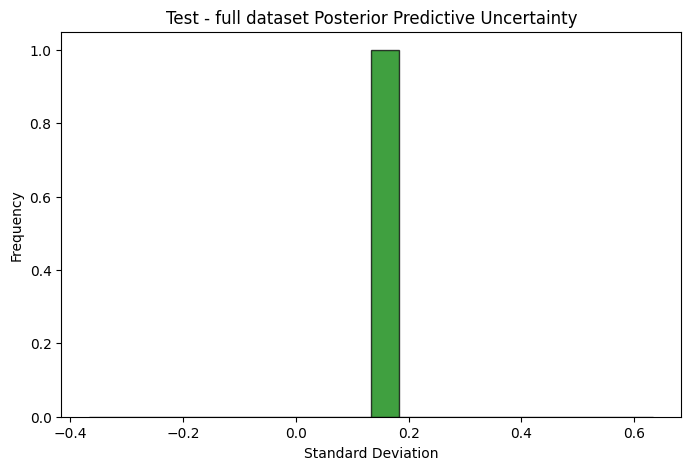

In [ ]:
# print(predictions)
predictions = np.array(predictions)
# print(predictions)
uncertainty_array = calculate_uncertainty_regression(predictions, label="Test - full dataset")


In [ ]:
# Calculăm pragul pe baza percentilului 95
threshold = np.percentile(uncertainty_array, 95)

print(f"Pragul ales (percentilul 95): {threshold:.2f}")

threshold = np.percentile(uncertainty_array, 90)

print(f"Pragul ales (percentilul 90): {threshold:.2f}")

Pragul ales (percentilul 95): 0.13
Pragul ales (percentilul 90): 0.13


extrapolated data

In [ ]:
# Citim setul de date
mpg = pd.read_csv("auto_mpg_preprocessed.csv")

# Eliminăm coloanele care nu sunt relevante pentru analiză
mpg = mpg.drop(columns=['name'])

# Completăm valorile lipsă
mpg['horsepower'] = mpg['horsepower'].fillna(mpg['horsepower'].mean())

# Transformăm coloana categorică 'origin' folosind one-hot encoding
mpg = pd.get_dummies(mpg, columns=['origin'], drop_first=True)

# Verificăm setul de date
print(mpg.head())


    mpg  cylinders  displacement  horsepower  weight  acceleration  \
0  18.0          8         307.0       130.0    3504          12.0   
1  15.0          8         350.0       165.0    3693          11.5   
2  18.0          8         318.0       150.0    3436          11.0   
3  16.0          8         304.0       150.0    3433          12.0   
4  17.0          8         302.0       140.0    3449          10.5   

   model_year  origin_japan  origin_usa  
0          70         False        True  
1          70         False        True  
2          70         False        True  
3          70         False        True  
4          70         False        True  


In [ ]:
from sklearn.model_selection import train_test_split

# 1. Separăm datele pe baza intervalului de antrenament
train_interval = (mpg['cylinders'] >= 3) & (mpg['cylinders'] <= 6)
train_data_normal = mpg[train_interval]

# 2. Selectăm toate datele pentru `cylinders = 8` (extrapolare)
data_cyl_8 = mpg[mpg['cylinders'] == 8]

# 3. Împărțim datele pentru `cylinders = 8` în test și "extra train" (30% pentru test)
test_data_extrapolated, extra_train_data = train_test_split(data_cyl_8, test_size=0.3, random_state=42)

# 4. Creăm setul complet de antrenament (adăugăm 70% din `cylinders = 8` la datele normale)
train_data = pd.concat([train_data_normal, extra_train_data])

# 5. Creăm seturile de caracteristici și țintă
X_train_extrapolated = train_data.drop(columns=['mpg'])
y_train_extrapolated = train_data['mpg']

X_test_extrapolated = test_data_extrapolated.drop(columns=['mpg'])
y_test_extrapolated = test_data_extrapolated['mpg']

# Verificăm dimensiunile
print(f"Număr de exemple în setul de antrenament: {len(X_train_extrapolated)}")
print(f"Număr de exemple în setul de test: {len(X_test_extrapolated)}")


Număr de exemple în setul de antrenament: 320
Număr de exemple în setul de test: 72


In [ ]:
# Verificăm suprapunerea între seturile de antrenament și test
overlap = X_test_extrapolated.merge(X_train_extrapolated, how='inner')
print(f"Număr de puncte în overlap între setul de test și cel de antrenament: {len(overlap)}")


Număr de puncte în overlap între setul de test și cel de antrenament: 0


In [ ]:
# Construim modelul pentru datele extrapolate
bnn_extrapolated = create_bayesian_network(X_train_extrapolated, y_train_extrapolated)

with bnn_extrapolated:
    # Ajustăm modelul folosind ADVI
    approx_extrapolated = pm.fit(100000, method="advi", random_seed=42)
    trace_extrapolated = approx_extrapolated.sample(draws=1000, return_inferencedata=True)


Output()

In [ ]:
predictions_extrapolated = None

with bnn_extrapolated:
    # Setăm datele de test
    pm.set_data({
        "model_input": X_test_extrapolated,
        "model_output": np.zeros(y_test_extrapolated.shape)  # Placeholder
    }, coords={"samples": np.arange(X_test_extrapolated.shape[0])})

    # Generăm predicții din posterior
    ppc_extrapolated = pm.sample_posterior_predictive(trace_extrapolated, var_names=["output"])
    predictions_draws_extrapolated = np.squeeze(ppc_extrapolated.posterior_predictive["output"])

    # Media predicțiilor pentru fiecare punct de test
    predictions_extrapolated = np.mean(predictions_draws_extrapolated, axis=0)
    print(predictions_extrapolated)

print(predictions_extrapolated)

Output()

<xarray.DataArray 'output' (output_dim_2: 72)> Size: 576B
array([22.18126828, 22.20814172, 22.08059651, 22.63313555, 22.13240096,
       22.19855009, 22.3061336 , 22.30895573, 22.20306076, 22.14110445,
       22.2018412 , 22.36297109, 22.12102934, 22.12477007, 22.13350917,
       22.46808537, 22.49315862, 22.24201257, 22.47045878, 22.24033358,
       22.50688479, 22.64269517, 22.74717264, 22.06104932, 22.47587641,
       22.35565246, 21.90816958, 22.49780428, 22.16112637, 22.57379067,
       22.2823854 , 22.36562953, 22.20027244, 22.16477636, 22.47291239,
       22.19019445, 22.74550198, 21.79241594, 22.34226248, 22.38338467,
       22.42988736, 22.47100786, 22.30183516, 22.14957384, 22.21301554,
       22.07340067, 22.11899297, 22.57204244, 22.55462068, 22.44581629,
       22.11531589, 22.00804071, 22.18511527, 22.55146372, 22.66214313,
       22.57919632, 22.16049191, 22.31167064, 22.57380626, 22.62368679,
       22.25637655, 22.0032127 , 22.39756576, 22.20810555, 21.91246123,
      

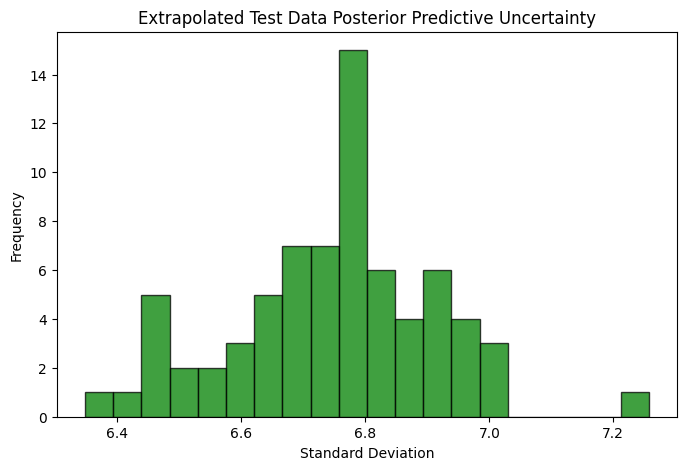

Primele 10 valori ale incertitudinii: <xarray.DataArray 'output' (output_dim_2: 10)> Size: 80B
array([6.57229306, 6.76671666, 6.5710849 , 6.75790984, 6.88190302,
       6.72638754, 6.47737728, 6.93496255, 6.78641843, 6.82883204])
Coordinates:
    chain         int64 8B 0
  * output_dim_2  (output_dim_2) int64 80B 0 1 2 3 4 5 6 7 8 9


In [ ]:
# Calculăm incertitudinea pentru punctele extrapolate
uncertainty_array_extrapolated = calculate_uncertainty_regression(
    predictions_draws_extrapolated, label="Extrapolated Test Data"
)

print(f"Primele 10 valori ale incertitudinii: {uncertainty_array_extrapolated[:10]}")


In [ ]:
# Calculăm pragul (e.g., al 95-lea percentil)
threshold_extrapolated = np.percentile(uncertainty_array_extrapolated, 95)
extrapolated_points = np.where(uncertainty_array_extrapolated > threshold_extrapolated)[0]

print(f"Pragul calculat: {threshold_extrapolated:.2f}")
print(f"Număr de puncte extrapolate detectate: {len(extrapolated_points)}")


Pragul calculat: 6.99
Număr de puncte extrapolate detectate: 4


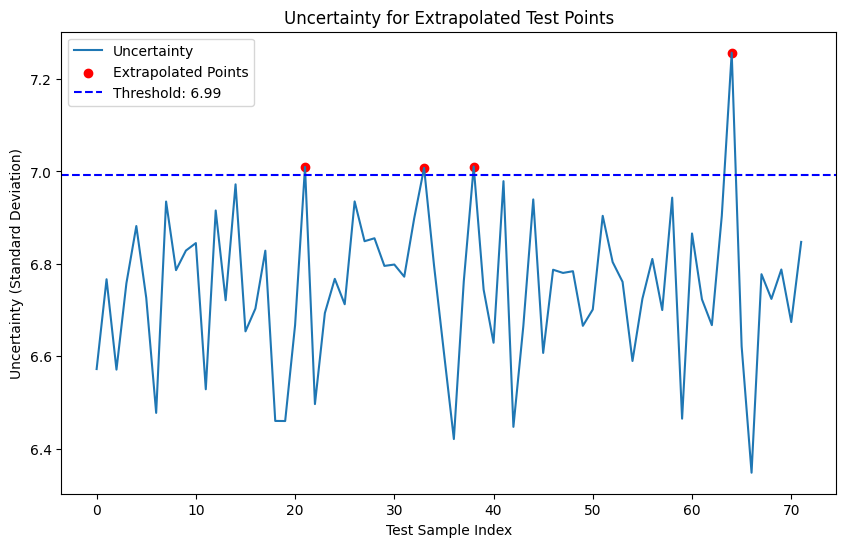

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(range(len(uncertainty_array_extrapolated)), uncertainty_array_extrapolated, label="Uncertainty")
plt.scatter(extrapolated_points, uncertainty_array_extrapolated[extrapolated_points], color="red", label="Extrapolated Points")
plt.axhline(y=threshold_extrapolated, color='blue', linestyle='--', label=f'Threshold: {threshold_extrapolated:.2f}')
plt.xlabel("Test Sample Index")
plt.ylabel("Uncertainty (Standard Deviation)")
plt.title("Uncertainty for Extrapolated Test Points")
plt.legend()
plt.show()



In [ ]:
# Analizăm punctele cu incertitudine mare
for idx in extrapolated_points:
    print(f"Indice: {idx}, Predicție: {predictions_extrapolated[idx]}, Valoare reală: {y_test_extrapolated.iloc[idx]}")



Indice: 21, Predicție: <xarray.DataArray 'output' ()> Size: 8B
array(22.64269517)
Coordinates:
    chain         int64 8B 0
    output_dim_2  int64 8B 21, Valoare reală: 14.0
Indice: 33, Predicție: <xarray.DataArray 'output' ()> Size: 8B
array(22.16477636)
Coordinates:
    chain         int64 8B 0
    output_dim_2  int64 8B 33, Valoare reală: 18.2
Indice: 38, Predicție: <xarray.DataArray 'output' ()> Size: 8B
array(22.34226248)
Coordinates:
    chain         int64 8B 0
    output_dim_2  int64 8B 38, Valoare reală: 16.0
Indice: 64, Predicție: <xarray.DataArray 'output' ()> Size: 8B
array(21.91246123)
Coordinates:
    chain         int64 8B 0
    output_dim_2  int64 8B 64, Valoare reală: 16.0


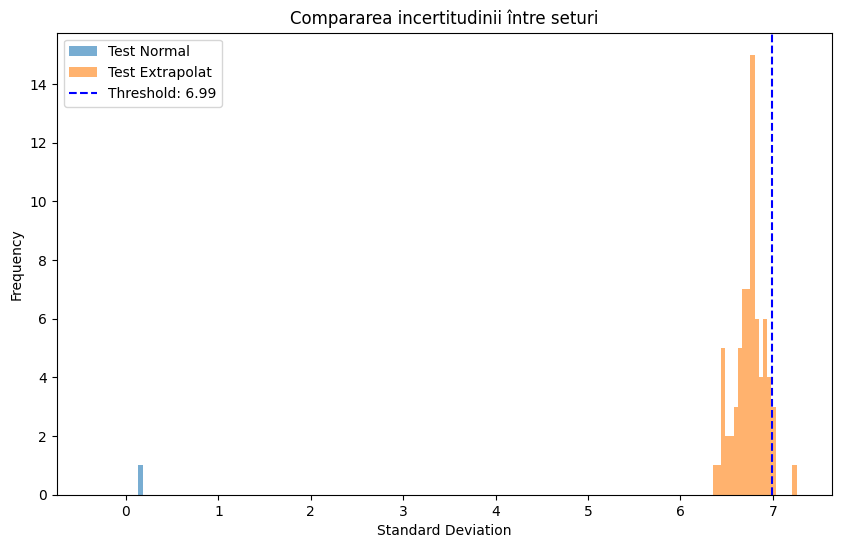

In [ ]:
plt.figure(figsize=(10, 6))
plt.hist(uncertainty_array, bins=20, alpha=0.6, label="Test Normal")
plt.hist(uncertainty_array_extrapolated, bins=20, alpha=0.6, label="Test Extrapolat")
plt.axvline(threshold_extrapolated, color='blue', linestyle='--', label=f'Threshold: {threshold_extrapolated:.2f}')
plt.xlabel("Standard Deviation")
plt.ylabel("Frequency")
plt.title("Compararea incertitudinii între seturi")
plt.legend()
plt.show()

I will also try with another dataset

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Descărcăm dataset-ul
url = "https://github.com/stedy/Machine-Learning-with-R-datasets/raw/master/insurance.csv"
data = pd.read_csv(url)

print(data.columns)
# Separăm caracteristicile (features) și ținta (target)
X = data.drop(columns=["charges"])  # Caracteristicile
y = data["charges"]  # Ținta

# Transformăm caracteristicile categoriale folosind one-hot encoding
X = pd.get_dummies(X, columns=["sex", "smoker", "region"], drop_first=True)

# Standardizăm caracteristicile numerice
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Împărțim datele în seturi de train și test
RANDOM_SEED = 9927
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=RANDOM_SEED)

# Convertim în format numpy
X_train = X_train.astype(np.float64)
X_test = X_test.astype(np.float64)
y_train = y_train.to_numpy().astype(np.float64)
y_test = y_test.to_numpy().astype(np.float64)

# Verificăm dimensiunile
print(f"Dimensiuni X_train: {X_train.shape}")
print(f"Dimensiuni X_test: {X_test.shape}")
print(f"Primele 5 exemple din X_train:\n{X_train[:5]}")
print(f"Primele 5 valori din y_train:\n{y_train[:5]}")

print("Shape of training data:", X_train.shape)
print("Shape of test data:", X_test.shape)


Index(['age', 'sex', 'bmi', 'children', 'smoker', 'region', 'charges'], dtype='object')
Dimensiuni X_train: (1070, 8)
Dimensiuni X_test: (268, 8)
Primele 5 exemple din X_train:
[[ 0.69727145  0.97878831  1.58092576 -1.0105187  -0.5074631  -0.56641788
   1.63579466 -0.56641788]
 [ 0.19886312 -0.73547651 -0.07876719 -1.0105187  -0.5074631  -0.56641788
   1.63579466 -0.56641788]
 [-0.65555117 -0.44839867 -0.90861367 -1.0105187  -0.5074631  -0.56641788
  -0.61132367 -0.56641788]
 [-0.58434998  1.44795552 -0.07876719  0.98959079 -0.5074631  -0.56641788
   1.63579466 -0.56641788]
 [ 0.69727145 -1.3211153  -0.07876719 -1.0105187  -0.5074631   1.76548098
  -0.61132367 -0.56641788]]
Primele 5 valori din y_train:
[10381.4787  7046.7222  4137.5227  3875.7341  9566.9909]
Shape of training data: (1070, 8)
Shape of test data: (268, 8)


Minimul valorilor target: 1121.8739
Maximul valorilor target: 63770.42801
Media valorilor target: 13270.422265141257
Deviația standard a valorilor target: 12110.011236693994


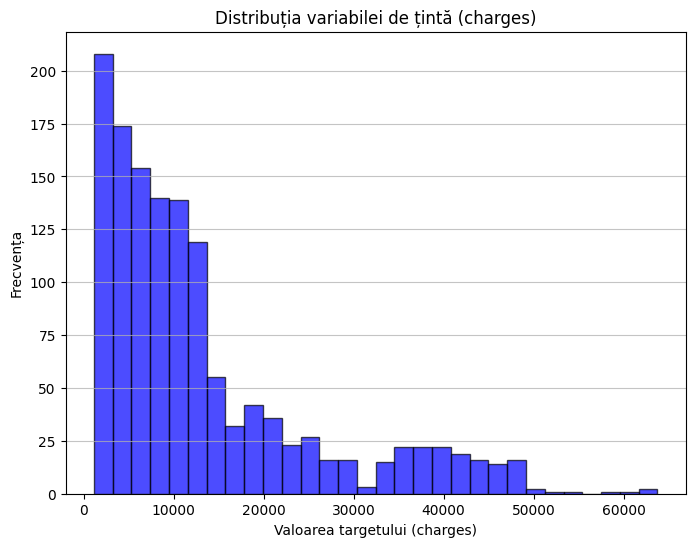

In [ ]:
# Calculăm statistici descriptive pentru variabila target
target_min = y.min()
target_max = y.max()
target_mean = y.mean()
target_std = y.std()

print(f"Minimul valorilor target: {target_min}")
print(f"Maximul valorilor target: {target_max}")
print(f"Media valorilor target: {target_mean}")
print(f"Deviația standard a valorilor target: {target_std}")

# Creăm un grafic pentru distribuția variabilei target
plt.figure(figsize=(8, 6))
plt.hist(y, bins=30, color='blue', alpha=0.7, edgecolor='black')
plt.title("Distribuția variabilei de țintă (charges)")
plt.xlabel("Valoarea targetului (charges)")
plt.ylabel("Frecvența")
plt.grid(axis='y', alpha=0.75)
plt.show()

In [ ]:
from scipy.stats import spearmanr
from sklearn.linear_model import LinearRegression

# Model liniar simplu pentru predicție
model = LinearRegression()
model.fit(X_train, y_train)

# Predicții pentru setul de test
predict = model.predict(X_test)

# Calculăm corelația Spearman între predicții și valorile reale
correlation, _ = spearmanr(y_test, predict)
print(f"Corelația Spearman pe setul de test: {correlation:.2f}")


Corelația Spearman pe setul de test: 0.92


In [ ]:
def create_bayesian_network_relu(input_data, output_data):
    """
    Definim o rețea neurală bayesiană pentru regresie.
    """
    coords = {
        "input_features": np.arange(input_data.shape[1]),
        "samples": np.arange(input_data.shape[0]),
    }

    with pm.Model(coords=coords) as bayesian_nn:
        # Definim datele de intrare și ieșire
        model_input = pm.Data("model_input", input_data, dims=("samples", "input_features"))
        model_output = pm.Data("model_output", output_data, dims="samples")

        # Priori pentru primul strat ascuns
        weights_layer1 = pm.Normal("weights_layer1", mu=0, sigma=2, shape=(input_data.shape[1], 20))
        biases_layer1 = pm.Normal("biases_layer1", mu=0, sigma=1, shape=(20,))

        # Priori pentru al doilea strat ascuns
        weights_layer2 = pm.Normal("weights_layer2", mu=0, sigma=2, shape=(20, 15))
        biases_layer2 = pm.Normal("biases_layer2", mu=0, sigma=1, shape=(15,))

        # Priori pentru stratul de ieșire
        weights_output = pm.Normal("weights_output", mu=0, sigma=1, shape=(15, 1))
        bias_output = pm.Normal("bias_output", mu=0, sigma=1)

        # Calculăm activările pentru fiecare strat
        # hidden_layer1 = pm.Deterministic("hidden_layer1", pm.math.tanh(pmath.dot(model_input, weights_layer1) + biases_layer1))
        hidden_layer1 = pm.Deterministic("hidden_layer1", pm.math.maximum(0, pmath.dot(model_input, weights_layer1) + biases_layer1))

        # hidden_layer2 = pm.Deterministic("hidden_layer2", pm.math.tanh(pmath.dot(hidden_layer1, weights_layer2) + biases_layer2))
        hidden_layer2 = pm.Deterministic("hidden_layer2", pm.math.maximum(0, pmath.dot(hidden_layer1, weights_layer2) + biases_layer2))

        network_output = pm.Deterministic("network_output", pm.math.flatten(pmath.dot(hidden_layer2, weights_output) + bias_output))

        predictions_det = pm.Deterministic("predictions", network_output)

        # Definim distribuția pentru ieșirea modelului
        #sigma = pm.HalfNormal("sigma", sigma=0.5)
        #sigma = pm.Exponential("sigma", lam=1)

        output = pm.Normal("output", mu=network_output, sigma=sigma, observed=model_output)

    return bayesian_nn


In [ ]:
#Construim modelul
bnn_relu = create_bayesian_network_relu(X_train, y_train)

with bnn_relu:
    # Ajustăm modelul folosind ADVI
    approx = pm.fit(90000, method="advi", random_seed=RANDOM_SEED)
    trace = approx.sample(draws=1000, return_inferencedata=True)


Fitting: ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╸ 100% 0:00:01 Average Loss = 15,012

In [ ]:
predictions_relu = None

with bnn_relu:
    # Actualizăm coordonatele și datele pentru setul de test
    pm.set_data({
        "model_input": X_test,
        "model_output": np.zeros(y_test.shape)  # Folosim valorile reale
    }, coords={"samples": np.arange(X_test.shape[0])})

    # Generăm predicții din posterior
    ppc = pm.sample_posterior_predictive(trace, var_names=["output"])
    #ppc = pm.sample_posterior_predictive(trace, var_names=["predictions"])

    predictions_draws = np.squeeze(ppc.posterior_predictive["output"])
    print(predictions_draws.shape)
    predictions_relu = np.mean(predictions_draws, axis=0)
    # print(predictions_relu)
    #Calculate spearman correlation between predicted and actual values
    spearman_corr = np.corrcoef(y_test, predictions, rowvar=False)[0, 1]
    print(f"Spearman correlation: {spearman_corr}")
    print(predictions_relu.shape)
# print("Out of with")
# print(predictions_relu)


Sampling ... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 100% 0:00:00 / 0:00:00

(1000, 268)
Spearman correlation: 0.8866470835479934
(268,)


Dimensiunile lui predictions_relu: (268,)


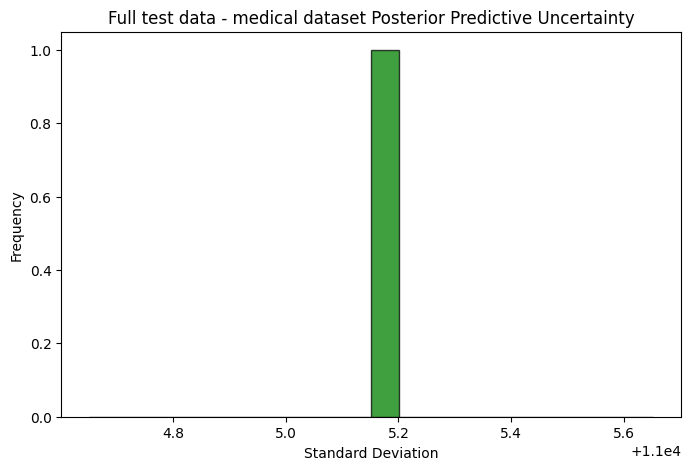

In [ ]:
# Calculăm incertitudinea pentru punctele extrapolate
# print(predictions_relu)
predictions_relu = np.array(predictions_relu)
print(f"Dimensiunile lui predictions_relu: {predictions_relu.shape}")

uncertainty_array_medical_dataset = calculate_uncertainty_regression(
    predictions_relu, label="Full test data - medical dataset"
)


In [ ]:
print(uncertainty_array_medical_dataset)

11005.151913852733


choose extrapolation on Age

Minim (vârsta): 18
Maxim (vârsta): 64
Media: 39.21
Deviația Standard: 14.05


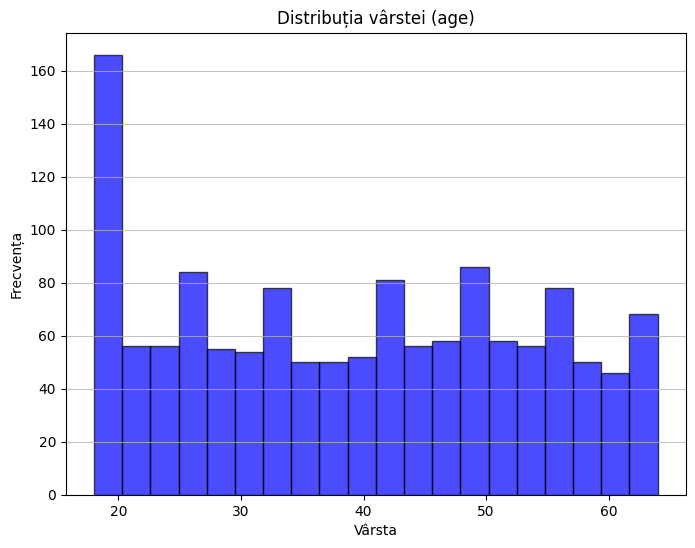

In [ ]:
# Calculăm statistici descriptive pentru `age`
age_min = data["age"].min()
age_max = data["age"].max()
age_mean = data["age"].mean()
age_std = data["age"].std()

# Afișăm valorile
print(f"Minim (vârsta): {age_min}")
print(f"Maxim (vârsta): {age_max}")
print(f"Media: {age_mean:.2f}")
print(f"Deviația Standard: {age_std:.2f}")

# Creăm un grafic pentru distribuția variabilei `age`
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))
plt.hist(data["age"], bins=20, color='blue', alpha=0.7, edgecolor='black')
plt.title("Distribuția vârstei (age)")
plt.xlabel("Vârsta")
plt.ylabel("Frecvența")
plt.grid(axis='y', alpha=0.75)
plt.show()


In [ ]:
# Interval pentru setul de antrenament
train_interval_age = (data["age"] >= 20) & (data["age"] <= 50)

# Setul de test (extrapolare): valori sub 20 sau peste 50
extrapolation_test_data = data[~train_interval_age]  # Complementele intervalului de train
extrapolation_train_data = data[train_interval_age]  # Datele pentru antrenament

# Separăm caracteristicile și ținta
X_train_extrapolation = extrapolation_train_data.drop(columns=["charges"])
y_train_extrapolation = extrapolation_train_data["charges"]
X_test_extrapolation = extrapolation_test_data.drop(columns=["charges"])
y_test_extrapolation = extrapolation_test_data["charges"]

# Transformăm variabilele categoriale și standardizăm caracteristicile
X_train_extrapolation = pd.get_dummies(X_train_extrapolation, columns=["sex", "smoker", "region"], drop_first=True)
X_test_extrapolation = pd.get_dummies(X_test_extrapolation, columns=["sex", "smoker", "region"], drop_first=True)

# Standardizare
scaler = StandardScaler()
X_train_extrapolation_scaled = scaler.fit_transform(X_train_extrapolation)
X_test_extrapolation_scaled = scaler.transform(X_test_extrapolation)

# Verificăm dimensiunile
print(f"Număr de exemple în setul de antrenament (extrapolare): {X_train_extrapolation_scaled.shape[0]}")
print(f"Număr de exemple în setul de test (extrapolare): {X_test_extrapolation_scaled.shape[0]}")


Număr de exemple în setul de antrenament (extrapolare): 845
Număr de exemple în setul de test (extrapolare): 493
